In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

sns.set(style='whitegrid')

c:\Users\jimen\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
ruta_excel = r"C:\Users\jimen\Desktop\Marsh Mclennan\2023 Budget FX Rates.xlsx"
ruta_csv = r"C:\Users\jimen\Desktop\Marsh Mclennan\Años\consolidated_data_2024.csv"

In [3]:
def cargar_datos(ruta_excel, ruta_csv):
    df_excel = pd.read_excel(ruta_excel, engine='openpyxl')
    df_csv = pd.read_csv(ruta_csv)
    
    return df_excel, df_csv

df_excel, df_csv = cargar_datos(ruta_excel, ruta_csv)

In [4]:
def preparar_datos(df_excel, df_csv):
    # Renombrar columna para hacer el merge
    df_excel.rename(columns={"CURR CODE": "Currency"}, inplace=True)
    
    # Hacer el merge usando la columna "Currency" como referencia
    df_merged = pd.merge(df_csv, df_excel[['Currency', 'BUDGET RATE']], on='Currency', how='left')
    
    # Convertir transacciones a USD
    df_merged['Transaction_USD'] = df_merged['Transaction'] * df_merged['BUDGET RATE']
    
    
    return df_merged
df_merged = preparar_datos(df_excel, df_csv)

In [5]:
df_merged.head()

,Client,Country,Currency,Transaction,date,BUDGET RATE,Transaction_USD
0,FLVWa,FIJI,MWK,1626847.37,2024-01-04,0.000974,1585.232614
1,FLVWa,GUYANA,LAK,44546375.72,2024-01-04,0.000058,2603.290197
2,FLVWa,BAHAMAS,MMK,1758344.03,2024-01-04,0.000476,837.305844
3,EKKL3,BOTSWANA,TWD,34098.47,2024-01-04,0.032055,1093.039754
4,EKKL3,OMAN,CLP,54075.56,2024-01-04,0.001053,56.921557


Indice Fecha

In [6]:
def preparar_series_temporales(df):
    # Convertir la columna 'date' al tipo datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Establecer la columna 'date' como índice
    df.set_index('date', inplace=True)
    
    # Asegurarse de que los datos estén ordenados por fecha
    df.sort_index(inplace=True)
    
    # Crear una serie temporal sumando los valores de 'Transaction_USD' por día
    ts_data = df['Transaction_USD'].resample('D').sum()  # 'D' es para diario. Cambiar a 'M' o 'Q' para mensual o trimestral.
    
    return ts_data

ts_data = preparar_series_temporales(df_merged)

Histórico

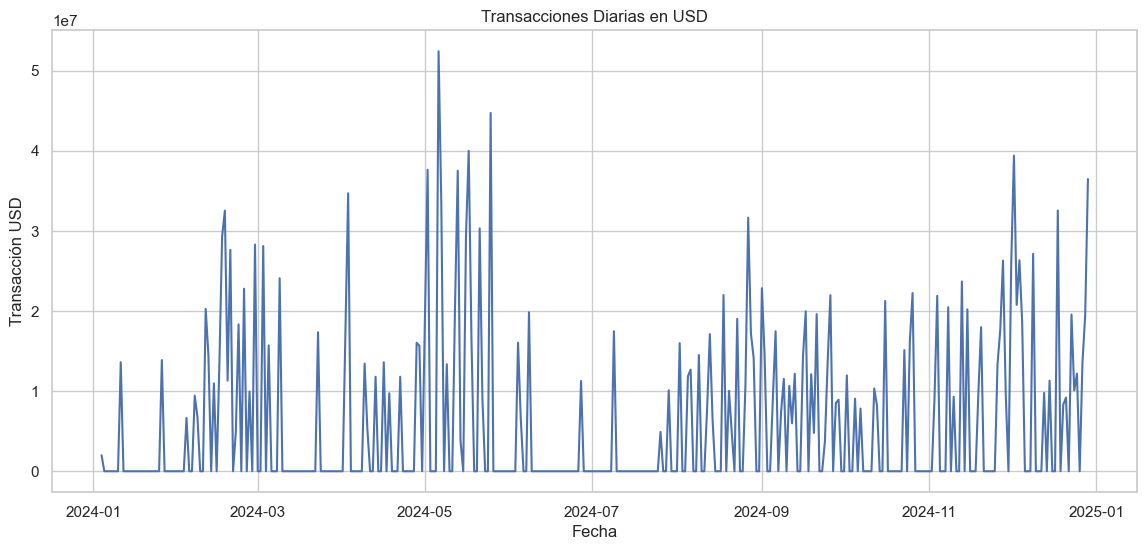

In [7]:
def graficar_serie_temporal(ts_data):
    plt.figure(figsize=(14, 6))
    plt.plot(ts_data, color='b')
    plt.title('Transacciones Diarias en USD')
    plt.xlabel('Fecha')
    plt.ylabel('Transacción USD')
    plt.grid(True)
    plt.show()

graficar_serie_temporal(ts_data)

Descomposición de la serie temporal

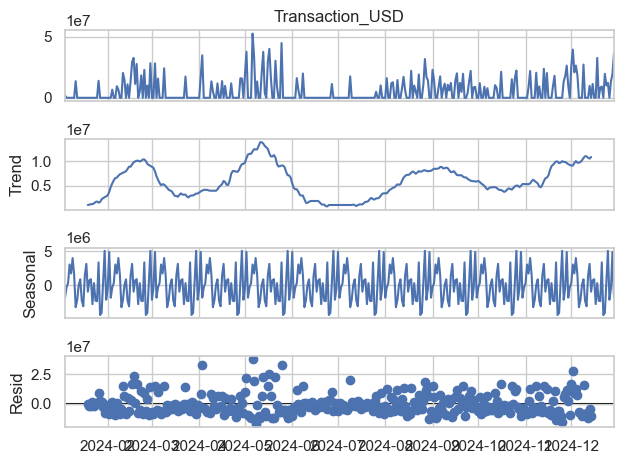

In [8]:
def descomposicion_serie_temporal(ts_data):
    # Descomposición usando un modelo aditivo
    descomposicion = seasonal_decompose(ts_data, model='additive', period=30)  # periodo 30 para ciclos mensuales
    descomposicion.plot()
    plt.show()

descomposicion_serie_temporal(ts_data)

Prueba de Dickey-Fuller para evaluar la estacionariedad

In [9]:
def prueba_adfuller(ts_data):
    resultado = adfuller(ts_data.dropna())
    print("Resultados de la Prueba Dickey-Fuller:")
    print(f"Estadístico ADF: {resultado[0]}")
    print(f"p-valor: {resultado[1]}")
    print("Valores Críticos:")
    for key, value in resultado[4].items():
        print(f"   {key}: {value}")

prueba_adfuller(ts_data)

Resultados de la Prueba Dickey-Fuller:
Estadístico ADF: -3.6151780806606815
p-valor: 0.00547739801859598
Valores Críticos:
   1%: -3.4490648539347544
   5%: -2.8697861692116478
   10%: -2.5711631253228306


Modelo ARIMA

Resultados del Modelo ARIMA:
                               SARIMAX Results                                
Dep. Variable:        Transaction_USD   No. Observations:                  360
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6354.419
Date:                Mon, 18 Nov 2024   AIC                          12714.838
Time:                        12:11:03   BIC                          12726.488
Sample:                    01-05-2024   HQIC                         12719.471
                         - 12-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3977      0.054     -7.333      0.000      -0.504      -0.291
ma.L1         -0.9977      0.070    -14.181      0.000      -1.136      -0.860
sigma2      1.768e+14  

c:\Users\jimen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


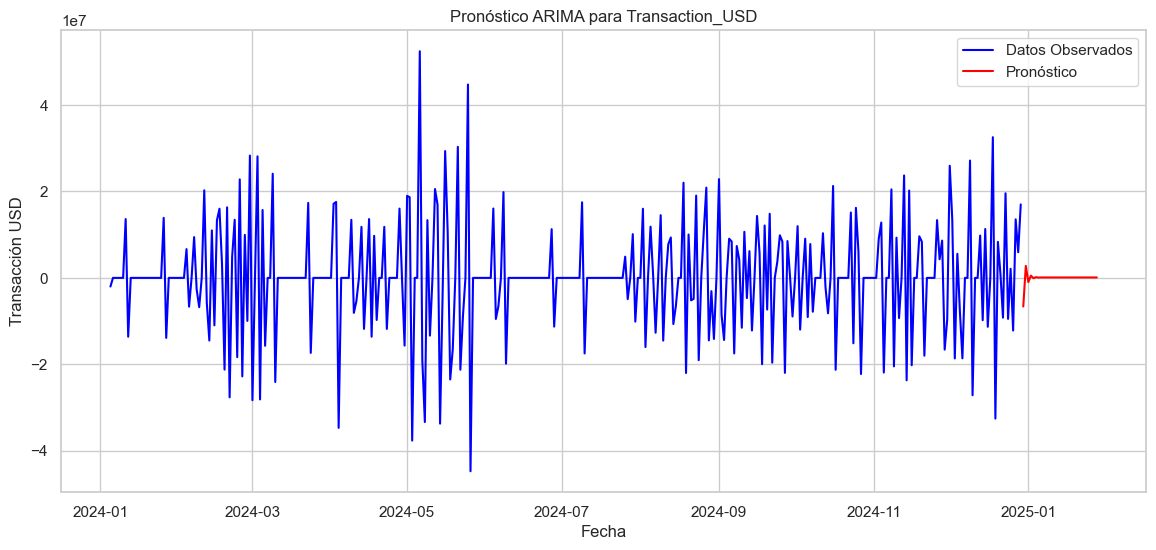

In [10]:
def modelado_arima(ts_data):
    # Primeras diferencias para asegurar Estacionariedad
    ts_data_diff = ts_data.diff().dropna()

    # Ajustar el modelo ARIMA (p, d, q)
    model = ARIMA(ts_data_diff, order=(1, 1, 1))  # Parámetros ajustables p, d, q
    arima_model = model.fit()

    # Mostrar los resultados del modelo ARIMA
    print("Resultados del Modelo ARIMA:")
    print(arima_model.summary())

    # Predecir los próximos valores
    forecast = arima_model.forecast(steps=30)  # Pronóstico de 30 días
    plt.figure(figsize=(14, 6))
    plt.plot(ts_data_diff, label='Datos Observados', color='blue')
    plt.plot(forecast, label='Pronóstico', color='red')
    plt.title('Pronóstico ARIMA para Transaction_USD')
    plt.xlabel('Fecha')
    plt.ylabel('Transacción USD')
    plt.legend()
    plt.grid(True)
    plt.show()

modelado_arima(ts_data)